In [6]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import requests
import time 
import csv
import os
from pprint import pprint
from pandas.io.json import json_normalize

In [7]:
# import csv file that is a breakdown of cases and deaths per day by state and county
df = pd.read_csv("CSV Folder/us-counties.csv.txt")

#group by state and date so that data is no longer at the county level, but at the state level
state_df = df.groupby(["state","date"])

#Create a data frame that has total cases by date by state
cases = state_df["cases"].sum()
workable_df = pd.DataFrame(cases)
workable_df = workable_df.reset_index()

#get the data for deaths per state per day into a series format to add to the cases dataframe
deaths = state_df["deaths"].sum()
death=pd.DataFrame(deaths)
work_death=death.reset_index()
DEAD = work_death["deaths"]

# Add Deaths column to the cases dataframe
workable_df["Deaths"]=DEAD

#Create final dataframe with just the columns we are interested in
final_df = workable_df[["date","state","cases","Deaths"]]

#Sort final df by date and re-index
final_df = final_df.sort_values("date")
final_df = final_df.reset_index(drop = True)

In [9]:
#Liz's Hospital Dataframe



#read in .csv file
hospital_data = pd.read_csv("CSV Folder/hospitals.csv")

#set index to state_name
hospital_data.set_index("state_name",inplace=True)

#group dataframe by state_name
hg = hospital_data.groupby('state_name')

#do count of hg dataframe (where it groups by states)to get total count of hospitals, doctors, staff,
#icu beds, and icu beds utilized. Then add each series to new dataframe called 'state_hospital_data'

hg["num_icu_be"].count()
state_hospital_data = pd.DataFrame(hg["num_icu_be"].count())

hospitals = hg["hospital_n"].count()
state_hospital_data["Number of Hospitals"]=hospitals

doctors = hg["num_licens"].count()
state_hospital_data["Number of Doctors"]=doctors

staff = hg["num_staffe"].count()
state_hospital_data["Number of Staff"]=staff

icu_beds = hg["num_icu_be"].count()
state_hospital_data["ICU Beds Available"]=icu_beds

bed_utiliz = hg["bed_utiliz"].count()
state_hospital_data["ICU Beds Utilized"]=bed_utiliz

#drop double num_icu_be column
state_hospital_data.drop("num_icu_be",axis=1, inplace = True)



In [10]:
# reaching out to API to get current overall state data pertaining to cases, tests, hospitalizations, and deaths
url3 = "https://covidtracking.com/api/states"
response3 = requests.get(url3)
#Turned entire response into a dataframe
US_df = json_normalize(response3.json(), errors='ignore')
#Narrowed df to specific columns of interest 
US_df = US_df.iloc[:,[0,1,8,9,22,16,10,19]]

#Read in a State Name Abbrev CSV so that df's could be joined with different state naming conventions
st_abrev = pd.read_csv("CSV Folder/Covid Analysis Data - StateNameAbrev.csv")

# Replacing the state abbreviation with names for joining to other data
tests_df = st_abrev.merge(US_df, how = 'inner',left_on = "Abbreviation",right_on = "state")

#Droping abbreviation column since no other dataset used abbrev.
tests_df.drop(columns = ["Abbreviation","state"],inplace = True)

#Joined hospital information with the general information
comb1_df= tests_df.merge(state_hospital_data,how = 'inner',left_on = "State",right_on = "state_name")
#comb1_df.drop(columns = "state_name", inplace = True)

#Read in file about rankings of aggressive measures limiting the virus spread
States_Most_Aggressive_Measures_df = pd.read_csv("CSV Folder/States with the Most Aggressive Measures in Limiting Virus Exposure.csv", encoding ='latin-1')

#Joined rankings data
comb2_df = comb1_df.merge(States_Most_Aggressive_Measures_df, how = 'inner', on = 'State' )

#Renamed Column Headers
comb2_df.rename(columns = {"positive":"Positive",
                           "negative":"Negative",
                           "pending":"Pending",
                           "totalTestResults": "Total Tested",
                           "recovered": "Recovered",
                           "hospitalizedCurrently":"Currently Hospitalized",
                           "death": "Total Deaths",
                           "num_icu_be":"ICU Beds",
                           "Prevention & Containment Rank": "Prevention & Containment Rank",
                           "Risk Factors & Infrastructure Rank": "Risk Factors & Infrastructure Rank",
                           "Economic Impact Rank": "Economic Impact Rank"}, inplace = True)

C:\Users\walsh\anaconda3\lib\site-packages\ipykernel_launcher.py:5: FutureWarning: pandas.io.json.json_normalize is deprecated, use pandas.json_normalize instead
  """


In [12]:
comb2_df.head()

,State,Positive,Negative,Pending,Total Tested,Recovered,Currently Hospitalized,Total Deaths,Number of Hospitals,Number of Doctors,Number of Staff,ICU Beds Available,ICU Beds Utilized,Overall Rank,Prevention & Containment Rank,Risk Factors & Infrastructure Rank,Economic Impact Rank,Delta in Overall Rank vs. March 23
0,Alabama,5025,40875,NaN,45900,NaN,NaN,167.0,120,120,120,66,109,48,48,45,2,-15
1,Alaska,321,9803,NaN,10124,161.0,46.0,9.0,28,28,28,7,23,3,2,11,40,11
2,Arizona,5064,49436,NaN,54500,1155.0,637.0,187.0,126,126,126,46,108,39,36,46,19,-1
3,Arkansas,1923,24630,NaN,26553,749.0,93.0,42.0,106,106,106,40,100,46,45,49,5,1
4,California,30978,259522,NaN,290500,NaN,4674.0,1208.0,466,466,466,302,401,18,15,44,16,-17


In [73]:
deathsbyState = comb2_df.loc[:,["State","Total Deaths"]]
deathsbyState.sort_values("Total Deaths", ascending = False,inplace = True)
deathsbyState["Percent of Deaths in US"]=round(deathsbyState["Total Deaths"]/deathsbyState["Total Deaths"].sum()*100,2)
deathsbyState.reset_index(drop = True)
USDeaths = deathsbyState["Total Deaths"].sum()
deathsbyStatePie = deathsbyState[deathsbyState["Percent of Deaths in US"]>1]
PercentTop = deathsbyStatePie["Percent of Deaths in US"].sum()
PercentOther = (100 - float(PercentTop))
OtherDeaths = USDeaths - deathsbyStatePie["Total Deaths"].sum()
print(deathsbyStatePie["Total Deaths"].sum())
print(OtherDeaths)
print(f" Total deaths in us is {USDeaths} and the percent of states with less than 1% is {PercentOther}")
Chart = deathsbyStatePie.append({"State":"Others","Total Deaths":OtherDeaths,"Percent of Deaths in US":PercentOther}, ignore_index = True)

34002.0
3141.0
 Total deaths in us is 37143.0 and the percent of states with less than 1% is 8.469999999999999


In [74]:
Chart

,State,Total Deaths,Percent of Deaths in US
0,New York,14347.0,38.63
1,New Jersey,4377.0,11.78
2,Michigan,2468.0,6.64
3,Massachusetts,1706.0,4.59
4,Illinois,1349.0,3.63
5,Connecticut,1331.0,3.58
6,Louisiana,1328.0,3.58
7,California,1208.0,3.25
8,Pennsylvania,1204.0,3.24
9,Florida,806.0,2.17


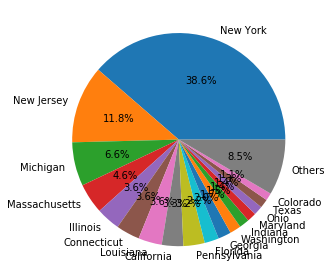

In [78]:
labels = Chart["State"]
sizes = Chart ["Total Deaths"]

plt.pie(sizes,labels = labels, autopct='%1.1f%%')
plt.tight_layout()